In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
import mode_analysis_code_original as ma

#create 3d array to hold data [ [ [x_p1_t0, x_p2_t0, x_p3_t0, ...],[y_p1_t0, y_p2_t0, ...], ... ],
#                              [ [x_p1_t1, x_p2_t1, x_p3_t1, ...],[y_p1_t1, y_p2_t1, ...], ... ],
#                                 . . .
#                              [ [x_p1_tn, x_p2_tn, x_p3_tn, ...],[y_p1_tn, y_p2_tn, ...], ... ] ]



#Open the binary file for reading
f = open("output.dat", "rb")


########## read number of particles (first number in data file) ##########
char_len = 1
char_empty = False
while not char_empty:
    f.seek(0)  #go to first character in file
    data_byte = f.read(char_len)
    num_particles = int(data_byte)
    char_len+=1
    next_char = f.read(1)
    if next_char ==  b" ":
        char_empty = True
        
print("Num particles: " + str(num_particles))

########## read number of recorded timesteps ##########
rec_steps = float(f.read(14))  #non-negative number in scientific notation has 12 characters
rec_steps = int(rec_steps)
print("Number of recorded steps: " + str(rec_steps))

f.read(1)  #read and ignore space

########## read number of total timesteps ##########
steps = float(f.read(12))  #non-negative number in scientific notation has 12 characters
steps = int(steps)
print("Number of steps: " + str(steps))

f.read(1)  #read and ignore space

########## read write rate ##########
write_per = float(f.read(12))  #non-negative number in scientific notation has 12 characters
write_per = int(write_per)
print("Write per: " + str(write_per))

f.read(1)  #read and ignore space

########## read duration ##########
duration = float(f.read(12))
print("Simulation duration: " + str(duration))

f.read(1)

########## read timestep ##########
dt = float(f.read(12))
print("Timestep: " + str(dt))

f.read(1)

########## read axial magnetic field ##########
data_byte = f.read(13) 
if float(data_byte) >= 0:  #if value is non-negative, only read 12 characters
    f.seek(-13,1)
    data_byte = f.read(12)
    Bz = float(data_byte)
else:  #if value is negative, read 13 characters
    Bz = float(data_byte)
f.read(1)

########## read k_z ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    kz = float(data_byte)
else:
    kz = float(data_byte)
f.read(1)

########## read delta ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    delta = float(data_byte)
else:
    delta = float(data_byte)
f.read(1)

########## read omega_R ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    omegaR = float(data_byte)
else:
    omegaR = float(data_byte)
f.read(1)

########## read phi_0 ##########
data_byte = f.read(13)
if float(data_byte) >= 0:
    f.seek(-13,1)
    data_byte = f.read(12)
    phi0 = float(data_byte)
else:
    phi0 = float(data_byte)
f.read(1)

print("Bz: " + str(Bz))
print("kz: " + str(kz))
print("delta: " + str(delta))
print("phi0: " + str(phi0))

########## read charges ##########
charges = np.array([])
for i in range(num_particles):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_charge = float(data_byte)
        charges = np.append(charges, this_charge)
    else:
        this_charge = float(data_byte)
        charges = np.append(charges, this_charge)
    f.read(1)
    
########## read masses ##########
masses = np.array([])
for i in range(num_particles):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_mass = float(data_byte)
        masses = np.append(masses, this_mass)
    else:
        this_mass = float(data_byte)
        masses = np.append(masses, this_mass)
        print("ERROR: NEGATIVE MASS")
    f.read(1)

print("Charges:")
print(charges)
print("Masses:")
print(masses)

####### beam parameters ############
char_len = 1
char_empty = False
num_beams_pos = f.tell()
while not char_empty:
    f.seek(num_beams_pos)  #go to first digit in num_beams
    data_byte = f.read(char_len)
    num_beams = int(data_byte)
    char_len+=1
    next_char = f.read(1)
    if next_char ==  b" ":
        char_empty = True
        
beam_S0 = np.array([]) #peak intensity
beam_khat = np.empty([3,num_beams]) #khat vectors of beams
beam_waist = np.array([]) #beam waists, -1 signifies uniform beam
beam_disp = np.empty([3, num_beams]) #beam displacement from origin
beam_det = np.array([]) #beam detuning from atomic transition

for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_S0 = float(data_byte)
        beam_S0 = np.append(beam_S0, this_S0)
    else:
        this_S0 = float(data_byte)
        beam_S0 = np.append(beam_S0, this_S0)
        print("ERROR: NEGATIVE INTENSITY")
    f.read(1)
    

for j in range(3):
    for i in range(num_beams):
        data_byte = f.read(13)
        if float(data_byte) >= 0:
            f.seek(-13,1)
            data_byte = f.read(12)
            this_k = float(data_byte)
            beam_khat[j][i] = this_k
        else:
            this_k = float(data_byte)
            beam_khat[j][i] = this_k
        f.read(1)
beam_khat = np.transpose(beam_khat)  #the ith row corresponds to the components of the khat vector for ith ion

for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_waist = float(data_byte)
        beam_waist = np.append(beam_waist, this_waist)
    else:
        this_waist = float(data_byte)
        beam_waist = np.append(beam_waist, this_waist)
    f.read(1)
'''
for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_disp = float(data_byte)
        beam_disp = np.append(beam_disp, this_disp)
    else:
        this_disp = float(data_byte)
        beam_disp = np.append(beam_disp, this_disp)
    f.read(1)'''
    
for j in range(3):
    for i in range(num_beams):
        data_byte = f.read(13)
        if float(data_byte) >= 0:
            f.seek(-13,1)
            data_byte = f.read(12)
            this_disp = float(data_byte)
            beam_disp[j][i] = this_disp
        else:
            this_disp = float(data_byte)
            beam_disp[j][i] = this_disp
        f.read(1)
beam_disp = np.transpose(beam_disp)  #the ith row corresponds to the components of the displacement vector for ith ion
    
for i in range(num_beams):
    data_byte = f.read(13)
    if float(data_byte) >= 0:
        f.seek(-13,1)
        data_byte = f.read(12)
        this_det = float(data_byte)
        beam_det = np.append(beam_det, this_det)
    else:
        this_det = float(data_byte)
        beam_det = np.append(beam_det, this_det)
    f.read(1)

print("Num beams: " + str(num_beams))
print("S0:")
print(beam_S0)
print("khat:")
print(beam_khat)
print("waist:")
print(beam_waist)
print("displacement:")
print(beam_disp)
#print(beam_disp[2][2])
print("detuning:")
print(beam_det)


############################## READ POS. & VEL. AT EACH TIMESTEP ##############################

time_counter = 0  #outermost index of data array, indexes timestep
type_counter = 0  #middle index which tells us to go to i.e. x positions array, or y velocities array, etc
val_counter = 0  #innermost index, indexes particle

times_rec = int((steps-1)/write_per)+2
times_rec = rec_steps
print("Times recorded: " + str(times_rec))
data = np.zeros((times_rec,6,num_particles))

while time_counter < times_rec:
    #read data for this timestep
    type_array = np.zeros((6, num_particles))  #has form [ [x_p1_t0, x_p2_t0, x_p3_t0, ...],[y_p1_t0, y_p2_t0, ...], ... ]
    while type_counter < 6:
        #for this data type, i.e. y-velocities, read data for each particle
        val_array = np.array([])  #has form [x_p1_t0, x_p2_t0, x_p3_t0, ...]
        while val_counter < num_particles:
            data_byte = f.read(13)
            #print(data_byte)
            if float(data_byte) >= 0 and str(float(data_byte))[0] != '-': #second coniditon is for -0.0e00
                #print(str(float(data_byte)))
                f.seek(-13,1)
                data_byte = f.read(12)
            
            this_val = float(data_byte)
            val_array = np.append(val_array, this_val)

            f.seek(1,1) #skip the space between values
            val_counter+=1
            
        type_array[type_counter] = val_array
        val_counter = 0
        type_counter+=1
    data[time_counter] = type_array
    type_counter=0
    time_counter+=1
    
print(data)
print(data.shape)
x_save = data[:,0,:]
y_save = data[:,1,:]
z_save = data[:,2,:]
vx_save = data[:,3,:]
vy_save = data[:,4,:]
vz_save = data[:,5,:]

np.savetxt("x_test_100_dir.csv", x_save, delimiter = ' ')
np.savetxt("y_test_100_dir.csv", y_save, delimiter = ' ')
np.savetxt("z_test_100_dir.csv", z_save, delimiter = ' ')
np.savetxt("vx_test_100_dir.csv", vx_save, delimiter = ' ')
np.savetxt("vy_test_100_dir.csv", vy_save, delimiter = ' ')
np.savetxt("vz_test_100_dir.csv", vz_save, delimiter = ' ')


Num particles: 100
Number of recorded steps: 10001
Number of steps: 20000
Write per: 2
Simulation duration: 2e-05
Timestep: 1e-09
Bz: 4.4588
kz: 9205570.0
delta: 0.001751114
phi0: 68.15164
Charges:
[1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19 1.602177e-19
 1.602177e

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import mode_analysis_code_original as ma

Final velcoity in z-direction: -6.8047


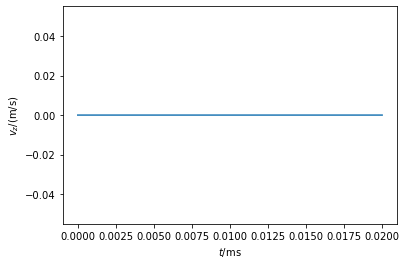

In [25]:
%matplotlib inline
times = []
for i in range(len(data)):
    times.append(i*write_per*dt)
plt.figure()
plt.plot(1.0e3 * np.array(times[:]), data[:,5,1])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$v_z/(\rm{m}/\rm{s})$')
print("Final velcoity in z-direction: " + str(data[-1,3,0]))

In [26]:
#transform x and y coordinates to rotating frame

start_step = 0
end_step = times_rec
print(omegaR/(2*np.pi))
pos_rot = np.empty((end_step-start_step, 2, num_particles))
pos_rot3D = np.empty((end_step-start_step, 3, num_particles))
for i in range(start_step, end_step):
    this_x = np.array([])
    this_y = np.array([])
    this_z = np.array([])
    for j in range(num_particles):
        xx = np.cos(omegaR*dt*i*write_per)*data[i,0,j]+np.sin(omegaR*dt*i*write_per)*data[i,1,j] #rotation
        yy = -np.sin(omegaR*dt*i*write_per)*data[i,0,j]+np.cos(omegaR*dt*i*write_per)*data[i,1,j] #rotation
        this_x = np.append(this_x, xx)
        this_y = np.append(this_y, yy)
        this_z = np.append(this_z, data[i,2,j])
    pos_rot[i-start_step,0] =this_x
    pos_rot[i-start_step,1] =this_y
    pos_rot3D[i-start_step,0] =this_x
    pos_rot3D[i-start_step,1] =this_y
    pos_rot3D[i-start_step,2] =this_z

179999.94345347016


In [27]:
vel_rot3D = np.empty((end_step-start_step, 3, num_particles))
for i in range(start_step, end_step):
    this_vx = np.array([])
    this_vy = np.array([])
    this_vz = np.array([])
    for j in range(num_particles):
        velxx = -omegaR*np.sin(omegaR*dt*i*write_per)*data[i,0,j] + np.cos(omegaR*dt*i*write_per)*data[i,3,j] + omegaR*np.cos(omegaR*dt*i*write_per)*data[i,1,j] + np.sin(omegaR*dt*i*write_per)*data[i,4,j] #rotation
        velyy = -omegaR*np.cos(omegaR*dt*i*write_per)*data[i,0,j]-np.sin(omegaR*dt*i*write_per)*data[i,3,j] - omegaR*np.sin(omegaR*dt*i*write_per)*data[i,1,j]+np.cos(omegaR*dt*i*write_per)*data[i,4,j] #rotation
        this_vx = np.append(this_vx, velxx)
        this_vy = np.append(this_vy, velyy)
        this_vz = np.append(this_vz, data[i,5,j])
    vel_rot3D[i-start_step,0] =this_vx
    vel_rot3D[i-start_step,1] =this_vy
    vel_rot3D[i-start_step,2] =this_vz

In [30]:
sfx = "1000_1e-4_083022"
np.savetxt("x_rot_" + sfx + ".csv", pos_rot3D[:,0,:], delimiter = ' ')
np.savetxt("y_rot_" + sfx + ".csv", pos_rot3D[:,1,:], delimiter = ' ')
np.savetxt("z_rot_" + sfx + ".csv", pos_rot3D[:,2,:], delimiter = ' ')
np.savetxt("vx_rot_" + sfx + ".csv", vel_rot3D[:,0,:], delimiter = ' ')
np.savetxt("vy_rot_" + sfx + ".csv", vel_rot3D[:,1,:], delimiter = ' ')
np.savetxt("vz_rot_" + sfx + ".csv", vel_rot3D[:,2,:], delimiter = ' ')

In [3]:
sfx = "_sim_dir"
load_xrot = np.loadtxt("x" + sfx + ".csv")
load_yrot = np.loadtxt("y" + sfx + ".csv")
load_zrot = np.loadtxt("z" + sfx + ".csv")
load_vxrot = np.loadtxt("vx" + sfx + ".csv")
load_vyrot = np.loadtxt("vy" + sfx + ".csv")
load_vzrot = np.loadtxt("vz" + sfx + ".csv")

In [23]:
print(np.mean(np.abs(load_zrot)))

0.0


In [4]:
print(pos_rot3D)
#print(load_xrot)

NameError: name 'pos_rot3D' is not defined

In [7]:
times_rec = 5001
num_particles = 256
load_pos_rot3D = np.zeros((times_rec,3,num_particles))
load_pos_rot2D = np.zeros((times_rec,2,num_particles))
load_vel_rot3D = np.zeros((times_rec,3,num_particles))
load_pos_rot3D[:,0,:] = load_xrot
load_pos_rot3D[:,1,:] = load_yrot
load_pos_rot3D[:,2,:] = load_zrot
load_pos_rot2D[:,0,:] = load_xrot
load_pos_rot2D[:,1,:] = load_yrot
load_vel_rot3D[:,0,:] = load_vxrot
load_vel_rot3D[:,1,:] = load_vyrot
load_vel_rot3D[:,2,:] = load_vzrot
print(load_pos_rot3D)

[[[ 1.034807e-05  9.195920e-06  2.196627e-05 ...  1.010945e-04
   -9.084938e-05  3.592625e-05]
  [-2.530992e-06  1.040660e-05  3.786922e-06 ... -6.654213e-05
    8.150882e-05  9.030397e-05]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]]

 [[ 1.035377e-05  9.172359e-06  2.195765e-05 ...  1.012447e-04
   -9.103350e-05  3.572191e-05]
  [-2.507581e-06  1.042737e-05  3.836594e-06 ... -6.631331e-05
    8.130313e-05  9.038500e-05]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]]

 [[ 1.035941e-05  9.148752e-06  2.194892e-05 ...  1.013945e-04
   -9.121716e-05  3.551740e-05]
  [-2.484157e-06  1.044809e-05  3.886247e-06 ... -6.608415e-05
    8.109703e-05  9.046556e-05]
  [ 0.000000e+00  0.000000e+00  0.000000e+00 ...  0.000000e+00
    0.000000e+00  0.000000e+00]]

 ...

 [[ 7.421265e-07  1.271363e-05  1.029946e-05 ... -3.257778e-05
    4.995435e-05  9.695671e-05]
  [-1.062727e-05 -5.588150e-06 -1.9768

ValueError: x and y must have same first dimension, but have shapes (2001,) and (2000,)

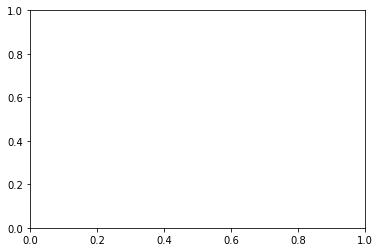

In [36]:
times = []
for i in range(len(data)):
    times.append(i*write_per*dt)
plt.figure()
plt.plot(1.0e3 * np.array(times[:]), pos_rot[:-1,0,1])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$v_x/(\rm{m}/\rm{s})$')

0.0


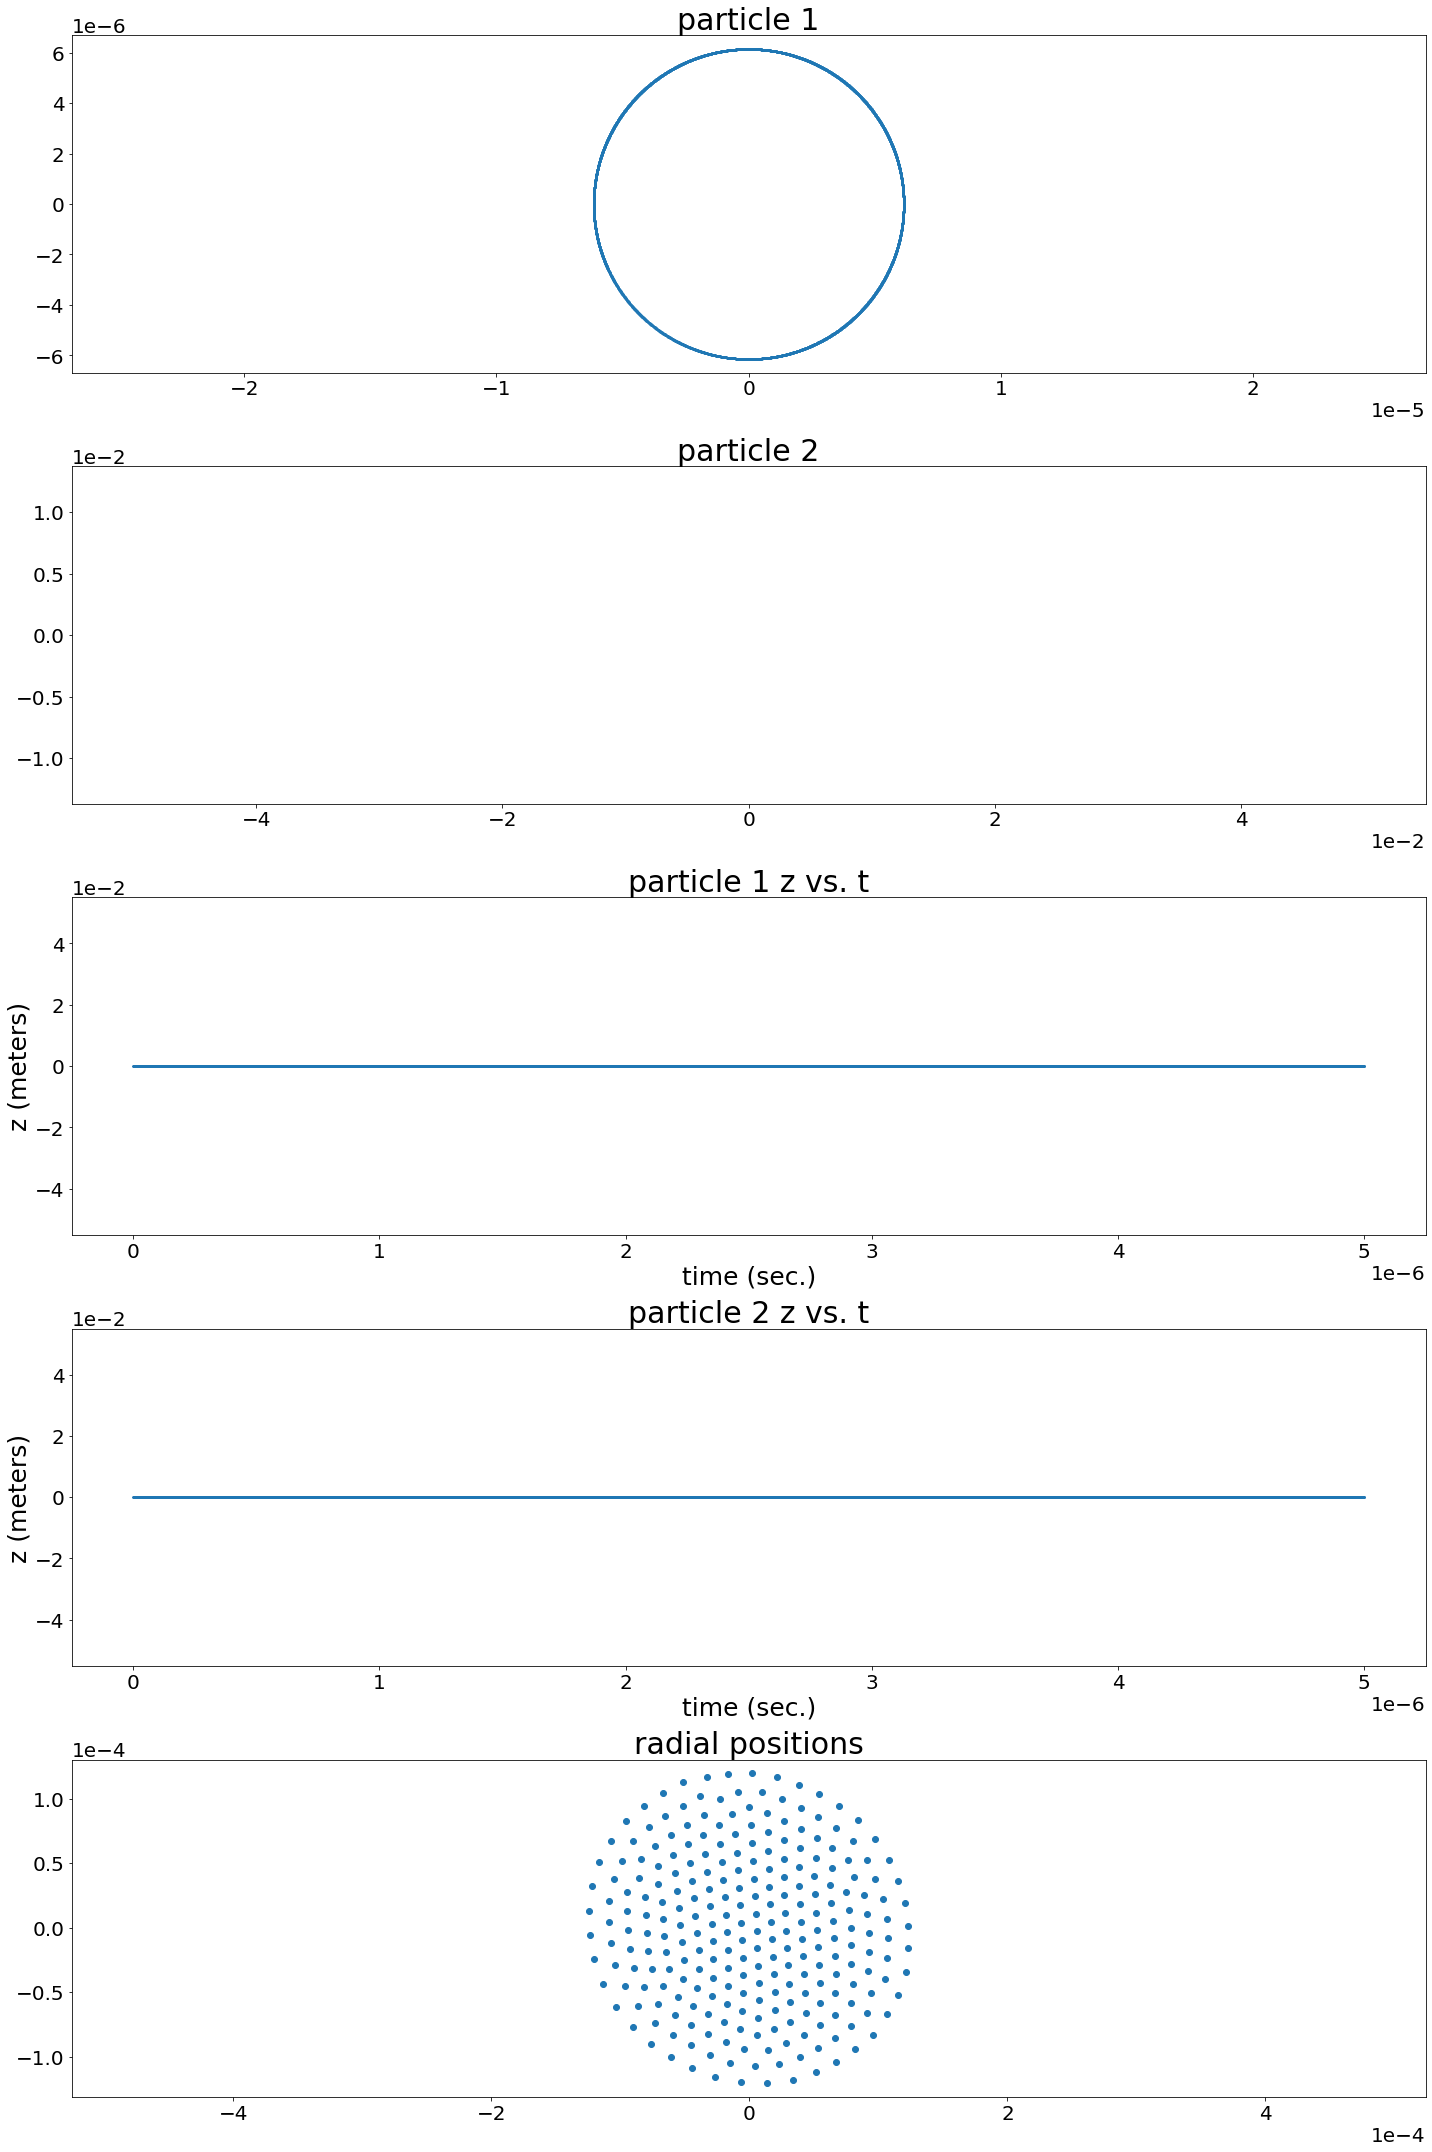

In [36]:
#some plots of particle motion in lab frame
%matplotlib inline

f, axs = plt.subplots(5,1,figsize=(20,30))

time = 450
axs[4].plot(data[time, 0, :], data[time, 1, :], 'o')
axs[4].axis('equal')
axs[4].set_title('radial positions', fontsize=30)
axs[4].tick_params(axis='both', labelsize=20)
axs[4].xaxis.offsetText.set_fontsize(20)
axs[4].yaxis.offsetText.set_fontsize(20)
axs[4].ticklabel_format(style='sci', scilimits = (0,0))

#plot y vs x for particle 1
axs[0].plot(data[:, 0, 0], data[:, 1, 0], '.', ms=3)
axs[0].axis('equal')
axs[0].set_title('particle 1', fontsize=30)
axs[0].tick_params(axis='both', labelsize=20)
axs[0].xaxis.offsetText.set_fontsize(20)
axs[0].yaxis.offsetText.set_fontsize(20)
axs[0].ticklabel_format(style='sci', scilimits = (0,0))

#plot y vs x for particle 2
axs[1].plot(data[10000:10500, 0, 1], data[10000:10500, 1, 1], '.', ms=3)
axs[1].axis('equal')
axs[1].set_title('particle 2', fontsize=30)
axs[1].tick_params(axis='both', labelsize=20)
axs[1].xaxis.offsetText.set_fontsize(20)
axs[1].yaxis.offsetText.set_fontsize(20)
axs[1].ticklabel_format(style='sci', scilimits = (0,0))

#plot z vs t for particle 1
axs[2].plot(dt*np.arange(len(data[:, 2, 0])), data[:, 2, 0], '.', ms=3)
#axs[2].axis('equal')
#axs[2].set_xlim(0,1e-05)
axs[2].set_title('particle 1 z vs. t', fontsize=30)
axs[2].set_xlabel('time (sec.)', fontsize=25)
axs[2].set_ylabel('z (meters)', fontsize=25)
axs[2].tick_params(axis='both', labelsize=20)
axs[2].xaxis.offsetText.set_fontsize(20)
axs[2].yaxis.offsetText.set_fontsize(20)
axs[2].ticklabel_format(style='sci', scilimits = (0,0))
print(min(data[:, 2, 0]))

#plot z vs t for particle 2
axs[3].plot(dt*np.arange(len(data[:, 2, 1])), data[:, 2, 1], '.', ms=3)
#axs[2].axis('equal')
#axs[3].set_xlim(0,1e-05)
axs[3].set_title('particle 2 z vs. t', fontsize=30)
axs[3].set_xlabel('time (sec.)', fontsize=25)
axs[3].set_ylabel('z (meters)', fontsize=25)
axs[3].tick_params(axis='both', labelsize=20)
axs[3].xaxis.offsetText.set_fontsize(20)
axs[3].yaxis.offsetText.set_fontsize(20)
axs[3].ticklabel_format(style='sci', scilimits = (0,0))

f.tight_layout()

plt.show()


In [13]:
#functions copied from crystal_mod to plot PSD

def psd(coord_traj,time_step,units=1e6,log=True):
    """computes the power spectrum of the coordianate trajectroy and converts the units of the frequecies from hertz
        default is MHz. Returns the log of the power spectrum by default, and the frequencies."""
    ps =  np.sum(np.abs(np.fft.fft(coord_traj,axis=0) / np.size(coord_traj[0,:]))**2, axis=1)
    freqs = np.fft.fftfreq(coord_traj[:,0].size, time_step)
    idx = np.argsort(freqs)
    freqs_norm=freqs[idx]/units
    if log == True:
        ps = np.log(ps[idx])
    return ps,freqs_norm

def plot_psd(freqs_norm,ps_log,ax,fig,
        title=None,label=None,normal_freqs=[],
        color='b'):
    if label==None: 
        label = 'PSD'
    if title ==None:
        title = 'Power Spectrum'
    ax.plot(freqs_norm, ps_log,label=label,color=color)
    if len(normal_freqs)!=0:
        switch = 0
        for norm_freq in normal_freqs:
            if switch == 0: 
                ax.axvline(x=norm_freq,color='r',label='Linear Modes'
                           ,alpha = 0.75,zorder = 1)
                switch += 1
            else: 
                ax.axvline(x=norm_freq,color='r',alpha = 0.75
                           ,zorder = 1)
        nf_min = np.min(normal_freqs);nf_max=np.max(normal_freqs)
        expand = .05*(nf_max - nf_min)
        ax.set_xlim(( nf_min-expand , nf_max+expand ))
    ax.set_ylim((-30, 0))
    ax.set_ylabel(r"$\ln(PSD)$ [A.U.]")
    ax.set_xlabel(r"Frequency [$MHz$]")
    ax.set_title(title)
    
def get_mode_ticks(labels,freqs,min_diff=0.05):
    assert len(labels)==len(freqs),"labels and freqs must be same length"
    diffs = np.diff(freqs)/(freqs[-1]-freqs[0])
    gdexs = np.append(np.where(diffs>min_diff),np.array([len(freqs)-1]))
    bdexs = np.array(np.where(diffs<=min_diff))
    tdexs = np.isin(gdexs,bdexs+1)
    fdexs = gdexs[np.where(np.logical_not(tdexs))]
    stops = gdexs[np.where(tdexs)]
    bgins = bdexs[np.where(np.isin(bdexs,gdexs+1))]
    assert len(bgins)==len(stops),'something went wrong'
    dexs  = np.append(gdexs,stops)
    freqs[stops] = (freqs[stops] + freqs[bgins])/2 
    labels[stops]  = [labels[bgins[i]]+'-'+labels[stops[i]] for i in range(len(bgins))]
    gfreqs = freqs[dexs] ; glabels = labels[dexs]
    return gfreqs,glabels 

/tmp/ipykernel_402449/487182422.py:11: RuntimeWarning: divide by zero encountered in log
  ps = np.log(ps[idx])
/tmp/ipykernel_402449/487182422.py:42: RuntimeWarning: invalid value encountered in true_divide
  diffs = np.diff(freqs)/(freqs[-1]-freqs[0])
/tmp/ipykernel_402449/487182422.py:43: RuntimeWarning: invalid value encountered in greater
  gdexs = np.append(np.where(diffs>min_diff),np.array([len(freqs)-1]))
/tmp/ipykernel_402449/487182422.py:44: RuntimeWarning: invalid value encountered in less_equal
  bdexs = np.array(np.where(diffs<=min_diff))


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.25146481]


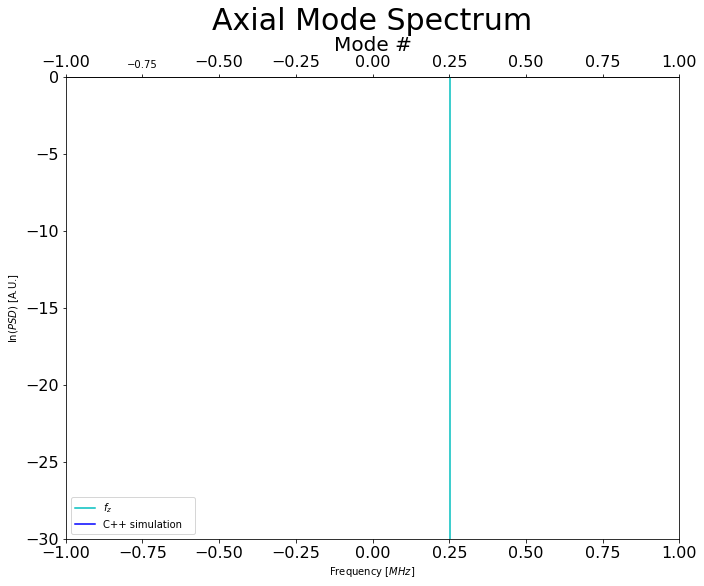

In [14]:
#Initialize mode analysis with same parameters as in set_parameters
num_ions=6
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=1.
frot=180000
method='bfgs'
frot_kHz = 1e-3*frot 
units = 1e6
ma_instance=ma.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)
ma_instance.run()

wrot = ma_instance.wrot
wc   = ma_instance.wc*ma_instance.wz
wz   = ma_instance.wz
beta = ma_instance.beta 
cycprime   = wc - 2*wrot
omegaplus  = (np.sqrt(cycprime**2 + 4*beta*wz**2)+cycprime)/2
omegaminus = (np.sqrt(cycprime**2 + 4*beta*wz**2)-cycprime)/2


#Axial mode PSD
pos_ax = data[:,2,:]
ps_ax, freq_norm_ax = psd(pos_ax, dt)

all_normal_freqs = ma_instance.planarEvalsE/units/2/np.pi
ax_normal_freqs = ma_instance.axialEvalsE/units/2/np.pi

print(ax_normal_freqs)

fig = plt.figure(figsize=(11,8.5),constrained_layout=False)
gs  = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, :])



ax_modes = np.arange(0,num_ions)
normal_freqs = ax_normal_freqs[ax_modes]
ax1.axvline(ma_instance.wz/units/np.pi/2
            ,color='c'
            ,label=r'$f_z$'
            ,zorder=2)
plot_psd(freq_norm_ax,ps_ax,ax1,fig
        ,label='C++ simulation   '
        ,color='b'
        )    
ax1.fill_between(freq_norm_ax,ps_ax,-30
        ,color='b'
        ,zorder=3
        )

secax_x = ax1.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (ax_modes+1))),dtype='<U5')
freqs,labels = get_mode_ticks(labels,normal_freqs)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax1.legend(loc='lower left')
ax1.set_title('Axial Mode Spectrum',fontsize=30)
ax1.set_xlim(-1,1)

plt.show()

[1.08817975e-06 1.70964253e-01 1.75836052e-01 2.59795064e-01
 2.60709744e-01 2.97700597e-01]
['1' '2' '3' '4' '5' '6']
[7.41317251 7.49810439 7.50263686 7.53509603 7.53987181 7.62870258]


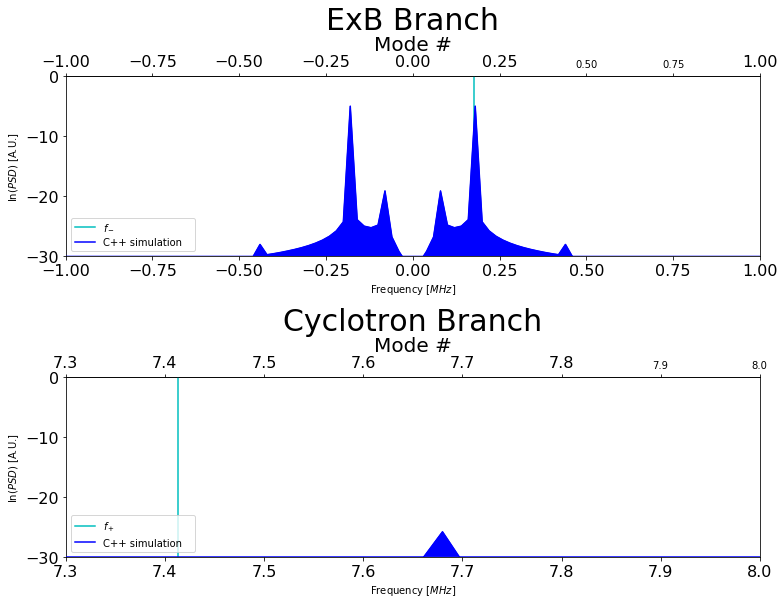

In [15]:
ps_rad,freq_norm_rad = psd(data[:,0,:],dt)

fig = plt.figure(figsize=(11,8.5),constrained_layout=False)
gs  = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])


mag_modes = np.arange(0,num_particles)
normal_freqs = all_normal_freqs[mag_modes]
ax1.axvline(omegaminus/units/np.pi/2
            ,color='c'
            ,label=r'$f_-$'
            ,zorder=2)
plot_psd(freq_norm_rad,ps_rad,ax1,fig,
        label='C++ simulation   ',color='b')    
ax1.fill_between(freq_norm_rad,ps_rad,-30
        ,color='b'
        ,zorder=3
        )

secax_x = ax1.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (mag_modes+1))),dtype='<U5')
print(normal_freqs)
print(labels)
freqs,labels = get_mode_ticks(labels,normal_freqs)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
#secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax1.legend(loc='lower left')
ax1.set_title('ExB Branch',fontsize=30)
ax1.set_xlim(-1,1)



cyc_modes = np.arange(num_ions,2*num_ions)
normal_freqs = all_normal_freqs[cyc_modes]
print(normal_freqs)
ax2.axvline(omegaplus/units/np.pi/2
            ,color='c'
            ,label=r'$f_+$'
            ,zorder=2)
plot_psd(freq_norm_rad,ps_rad,ax2,fig,
        label='C++ simulation   '
        ,color='b'
        )
ax2.fill_between(freq_norm_rad,ps_rad,-30
        ,color='b'
        ,zorder=3
        )

ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
secax_x = ax2.secondary_xaxis('top')
secax_x.set_xlabel('Mode #',fontsize=20)
labels  = np.array(list(map(str, (cyc_modes+1))),dtype='<U5')
freqs,labels = get_mode_ticks(labels,normal_freqs)
#secax_x.set_xticks(freqs) 
secax_x.set_xticklabels(labels,fontsize=16)
ax2.legend(loc='lower left')
ax2.set_title('Cyclotron Branch',fontsize=30)
#ax2.set_xlim(0,omegaplus/units/np.pi/2)
ax2.set_xlim(7.3,8)



plt.tight_layout()
#plt.savefig(pdir+'psd_comparison_nlVlin_'+lab_sim+'.png')
plt.show()

In [16]:
#plt.psd(data[:, 0, 3], Fs=10**9)
#plt.show()

#transform x and y coordinates to rotating frame

start_step = 0
end_step = 40000
omegaRp = omegaR
print(omegaRp/(2*np.pi))
pos_rot = np.empty((end_step-start_step+1, 2, num_particles))
for i in range(start_step, end_step+1):
    this_x = np.array([])
    this_y = np.array([])
    for j in range(num_particles):
        xx = np.cos(omegaRp*dt*i)*data[i,0,j]+np.sin(omegaRp*dt*i)*data[i,1,j] #rotation
        yy = -np.sin(omegaRp*dt*i)*data[i,0,j]+np.cos(omegaRp*dt*i)*data[i,1,j] #rotation
        this_x = np.append(this_x, xx)
        this_y = np.append(this_y, yy)
    pos_rot[i-start_step,0] =this_x
    pos_rot[i-start_step,1] =this_y

179999.94345347016


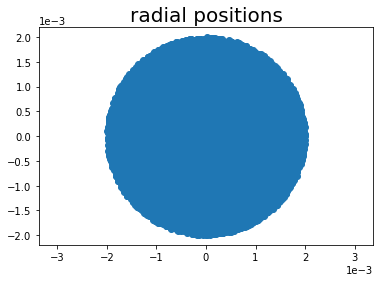

In [10]:
%matplotlib inline
#plot x and y in rotating frame
ax = plt.subplot()
step = 0 #between start_step and end_step
ax.plot(pos_rot[step, 0, :], pos_rot[step, 1, :], 'o')
ax.axis('equal')
ax.set_title('radial positions', fontsize=20)
ax.tick_params(axis='both', labelsize=10)
ax.xaxis.offsetText.set_fontsize(10)
ax.yaxis.offsetText.set_fontsize(10)
ax.ticklabel_format(style='sci', scilimits = (0,0))

In [30]:
#Rotating frame animation
from matplotlib.animation import FuncAnimation

class animate:
    def __init__(self,posall,units=1e6, title = "Title"):
        max_slices = 10**5
        len_slices = np.size(posall[:,0,0])
        if len_slices<max_slices: 
            sl=len_slices
        else: 
            sl=max_slices
        
        self.posall = posall


        self.x = []
        self.y = []

        self.positions1 = self.posall*units


        self.figure, self.ax = plt.subplots(figsize=(10,10))
        self.lim = np.max(np.abs(posall[0,:,:]*units))*2
        self.points1, = self.ax.plot(self.x, self.y
                                    ,'bo'
                                    ,zorder=2
                                    ,label='Particle'
                                    ,markersize=5)
        self.lines1, = self.ax.plot(self.x, self.y
                ,'ro'
                ,zorder=1
                ,label='Trail'
                ,markersize=0.1)
        self.ax.legend()
        plt.title(title)
        self.ax.set_xlabel(r'x [$\mu m$]')
        self.ax.set_ylabel(r'y [$\mu m$]')
        self.ax.set_aspect(1)

    def func_animate(self,frame_number,skip=1,tail=10**3,dots_every=1):
        self.ax.set_ylim((-self.lim,self.lim))
        self.ax.set_xlim((-self.lim,self.lim))
        x1 = self.positions1[frame_number*skip,0,:]
        y1 = self.positions1[frame_number*skip,1,:]
        if frame_number*skip-tail >= 0:
            index = np.arange(frame_number*skip-tail,
                                frame_number*skip,
                                dots_every)
            linex1=self.positions1[index,0,:]
            liney1=self.positions1[index,1,:]
        else:
            index = np.arange(0,frame_number*skip,dots_every)
            linex1=self.positions1[index,0,:]
            liney1=self.positions1[index,1,:]

        thetime = 1e-8*float(frame_number*skip)/1e-6
        #self.ax.annotate(r"Time =%1.0f[$\mu s$]" %thetime, xy=(0.1, 0.04),\
        #            xycoords='axes fraction',size=10,\
        #            bbox=dict(boxstyle='round', fc='w'))
        self.points1.set_data(x1,y1)
        self.lines1.set_data(linex1,liney1)

In [32]:
pos_rot_cut = np.copy(pos_rot)
pos_rot_cut_3D = np.copy(pos_rot3D)
already_cut=0
for i in range(num_particles):
    print(i)
    if abs(pos_rot3D[-1, 2, i]) > 1*10**-6:
        pos_rot_cut = np.delete(pos_rot_cut, i-already_cut, 2)
        #pos_rot_cut_3D = np.delete(pos_rot_cut_3D, i-already_cut, 2)
        already_cut+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [15]:
print(pos_rot_cut_3D.shape)
print(pos_rot_cut_3D)


NameError: name 'pos_rot_cut_3D' is not defined

<IPython.core.display.Javascript object>


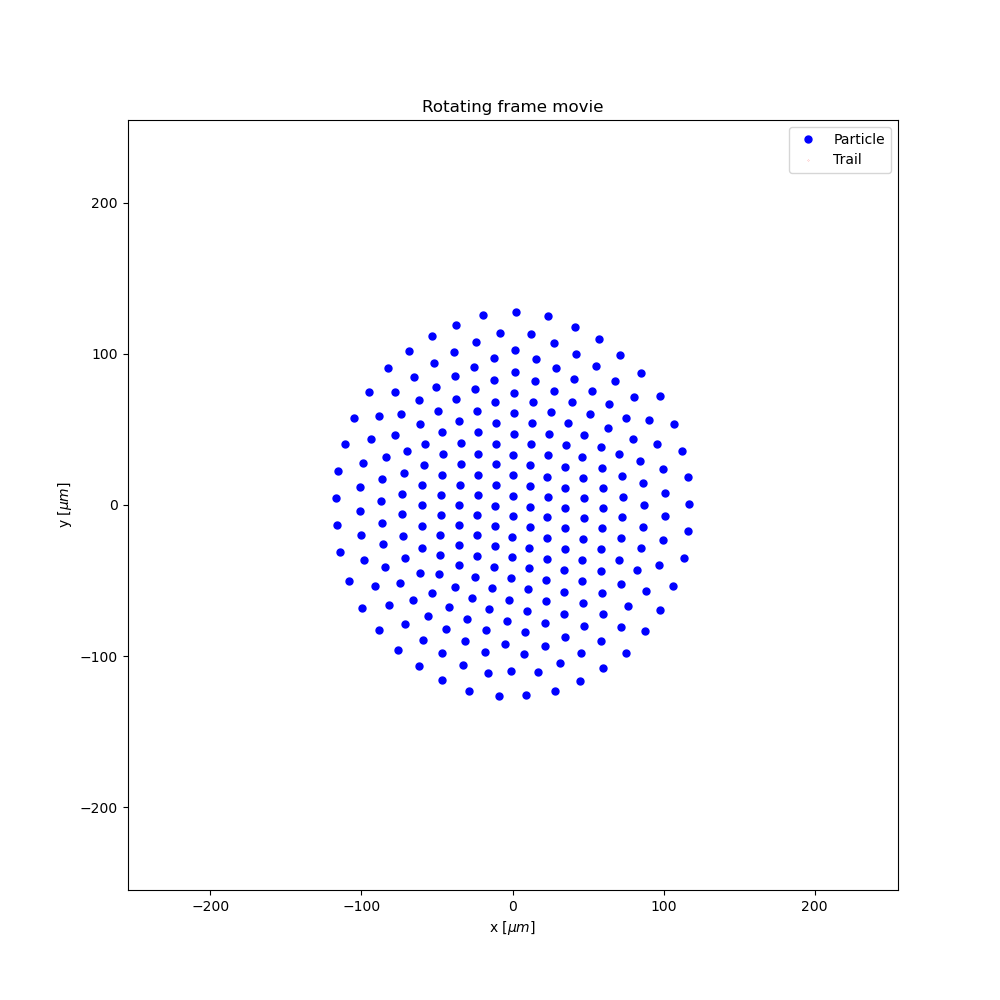

In [31]:
%matplotlib notebook
from matplotlib.animation import FFMpegWriter
    
#rot_anim = animate(load_pos_rot2D, title = "Rotating frame movie")
rot_anim = animate(pos_rot, title = "Rotating frame movie")

#for i in range(1000):
#    this_anim.func_animate(i)
#ani_rot = FuncAnimation(
#    rot_anim.figure, rot_anim.func_animate, interval=1, save_count = 100, repeat = False)
ani_rot = FuncAnimation(
    rot_anim.figure, rot_anim.func_animate, frames =300, interval=10)
writervideo = FFMpegWriter(fps=60)
ani_rot.save('rotating_2D_10000_changeB.mp4', writer=writervideo)


In [32]:
#Rotating frame animation
from matplotlib.animation import FuncAnimation

class animate3D:
    def __init__(self,posall,units=1e6, title = "Title"):
        max_slices = 10**5
        len_slices = np.size(posall[:,0,0])
        if len_slices<max_slices: 
            sl=len_slices
        else: 
            sl=max_slices
        
        self.posall = posall


        self.x = []
        self.y = []
        self.z = []

        self.positions1 = self.posall*units

        self.figure = plt.figure(figsize=(10, 10))
        self.ax = self.figure.add_subplot(projection='3d')
        #self.figure, self.ax = plt.subplots(figsize=(12,12))
        self.lim = np.max(np.abs(posall[0,:,:]*units))*2
        self.points1, = self.ax.plot(self.x, self.y, self.z
                                    ,'bo'
                                    ,zorder=2
                                    ,label='Particle'
                                    ,markersize=0.3)
        #self.lines1, = self.ax.plot(self.x, self.y, self.z
        #        ,'ro'
        #        ,zorder=1
        #        ,label='Trail'
        #        ,markersize=0.1)
        self.ax.legend()
        plt.title(title)
        self.ax.set_xlabel(r'x [$\mu m$]')
        self.ax.set_ylabel(r'y [$\mu m$]')
        self.ax.set_zlabel(r'z [$\mu m$]')
        #self.ax.set_aspect(1)

    def func_animate(self,frame_number,skip=1,tail=10**3,dots_every=1):
        self.ax.set_ylim((-self.lim,self.lim))
        self.ax.set_xlim((-self.lim,self.lim))
        self.ax.set_zlim((-self.lim,self.lim))
        x1 = self.positions1[frame_number*skip,0,:]
        y1 = self.positions1[frame_number*skip,1,:]
        z1 = self.positions1[frame_number*skip,2,:]
        if frame_number*skip-tail >= 0:
            index = np.arange(frame_number*skip-tail,
                                frame_number*skip,
                                dots_every)
            #linex1=self.positions1[index,0,:]
            #liney1=self.positions1[index,1,:]
            #linez1=self.positions1[index,2,:]
        else:
            index = np.arange(0,frame_number*skip,dots_every)
            #linex1=self.positions1[index,0,:]
            #liney1=self.positions1[index,1,:]
            #linez1=self.positions1[index,2,:]

        thetime = 1e-8*float(frame_number*skip)/1e-6
        #self.ax.annotate(r"Time =%1.0f[$\mu s$]" %thetime, xy=(0.1, 0.04),\
        #            xycoords='axes fraction',size=10,\
        #            bbox=dict(boxstyle='round', fc='w'))
        self.points1.set_data(x1,y1)
        self.points1.set_3d_properties(z1) 
        #self.lines1.set_data(linex1,liney1)
        #self.lines1.set_3d_properties(linez1) 

<IPython.core.display.Javascript object>


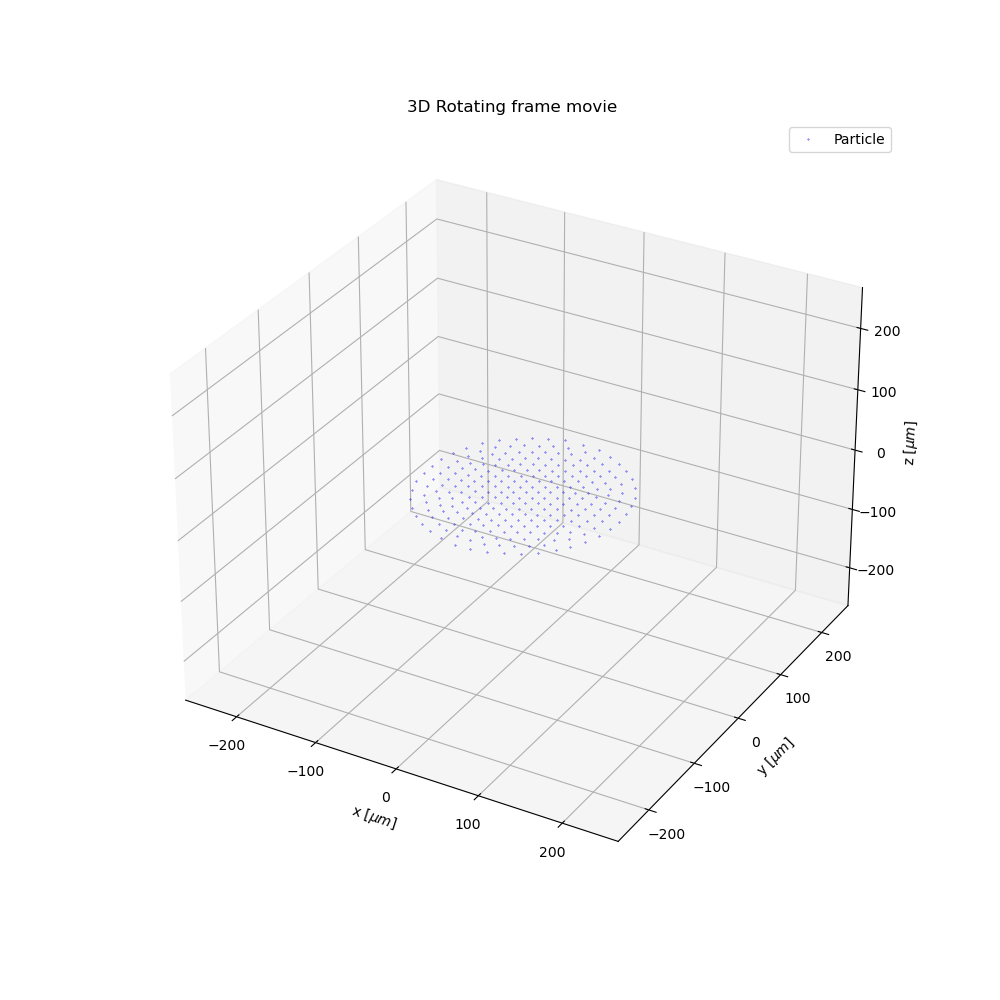

In [33]:
%matplotlib notebook
from matplotlib.animation import FFMpegWriter

#rot_anim = animate3D(load_pos_rot3D, title = "3D Rotating frame movie")
rot_anim = animate3D(pos_rot3D, title = "3D Rotating frame movie")
#for i in range(1000):
#    this_anim.func_animate(i)
#ani_rot = FuncAnimation(
#    rot_anim.figure, rot_anim.func_animate, interval=1, save_count = 100, repeat = False)
ani_rot = FuncAnimation(
    rot_anim.figure, rot_anim.func_animate, frames =300, interval=200)
writervideo = FFMpegWriter(fps=60)
ani_rot.save('rotating_3D_1000_1e-4_083022.mp4', writer=writervideo)

In [36]:
print(pos_rot)
print(pos_rot3D)

[[[-1.35070900e-04 -5.92883600e-04 -1.12091900e-03 ...  2.57546100e-04
   -5.15047900e-04  9.36153700e-05]
  [-2.69416500e-05 -3.55953900e-04  9.98963500e-04 ...  9.42501000e-04
   -4.28420500e-04 -3.36537900e-04]]

 [[-6.22251982e-05 -3.05433681e-04 -3.46806640e-04 ...  2.41328703e-04
   -2.81771845e-04 -5.91394478e-06]
  [ 6.92820750e-06 -7.23164400e-05  5.88401821e-04 ...  3.73094024e-04
   -1.14512872e-04 -1.58910693e-04]]

 [[-2.64615103e-05 -1.41507018e-04 -6.69868242e-05 ...  1.55701341e-04
   -1.37171790e-04 -2.45739282e-05]
  [ 1.14644468e-05  1.14236462e-05  3.02134988e-04 ...  1.27176750e-04
   -1.00568111e-05 -6.77813867e-05]]

 ...

 [[-1.58348010e-05 -2.72183211e-05  1.68225093e-05 ...  3.40099182e-05
   -2.76223234e-05 -1.76805054e-05]
  [ 1.59698974e-06  1.53008390e-05  4.88510657e-05 ...  1.81177808e-06
    7.48552231e-06 -6.99770389e-06]]

 [[-1.58348412e-05 -2.72323745e-05  1.67802592e-05 ...  3.40103862e-05
   -2.76279531e-05 -1.76830359e-05]
  [ 1.59219981e-06  1.5

<IPython.core.display.Javascript object>


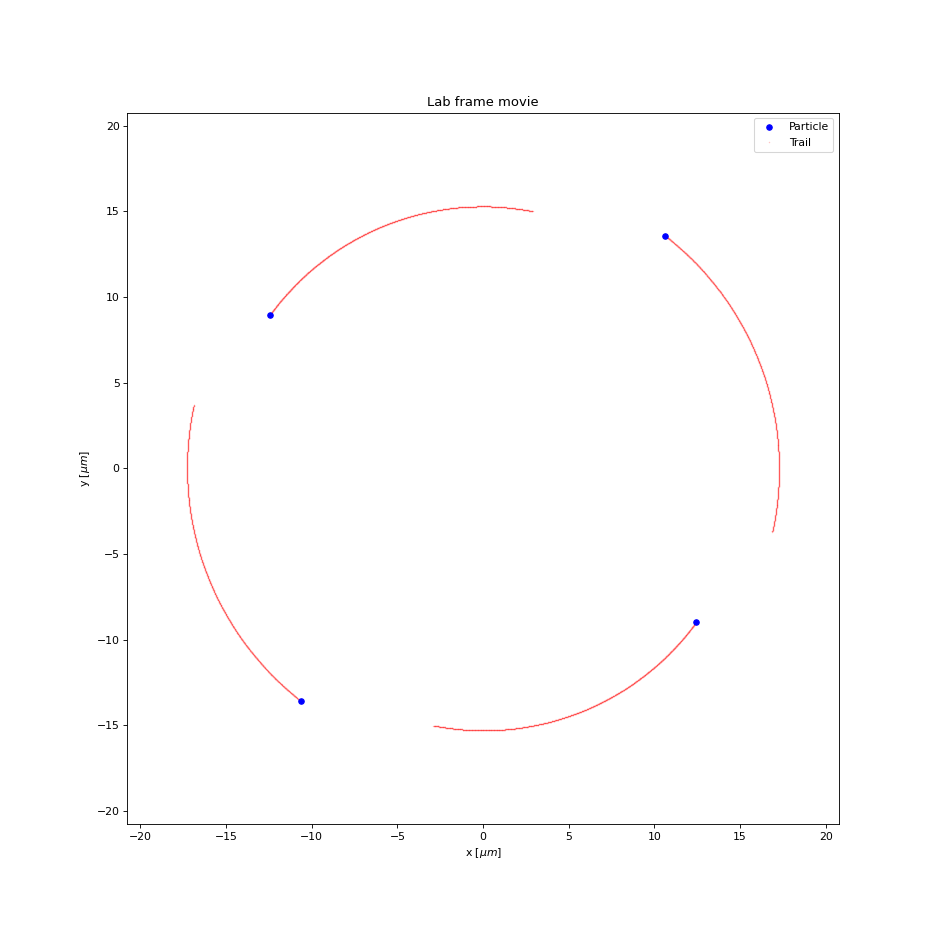

In [163]:
pos_lab = data[:, 0:2, :]
lab_anim = animate(pos_lab, title="Lab frame movie")
#for i in range(1000):
#    this_anim.func_animate(i)
ani_lab = FuncAnimation(
    lab_anim.figure, lab_anim.func_animate, frames = 4000, interval=10)
writervideo = FFMpegWriter(fps=60)
ani_lab.save('lab_4000frames_no_pert.mp4', writer=writervideo)

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

# creating a blank window
# for the animation
fig = plt.figure()
xmin = -0.3*10**-8-4*10**-3
xmax = 0.3*10**-8-4*10**-3
ymin = 0*10**-9
ymax = 4.2*10**-9
axis = plt.axes(xlim =(xmin,xmax),
                ylim =(ymin,ymax))
 
line, = axis.plot([], [], lw = 0.1)
 
# what will our line dataset
# contain?
def init():
    line.set_data([], [])
    return line,
 
# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []

# animation function
def animate(i):
    x = data[i,0,0]
    y = data[i,1,0]     
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
     
    return line,

# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 200,
                            interval = 100,
                            blit = True)
 
# saves the animation in our desktop
#anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 30)

In [ ]:
%matplotlib notebook
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

# creating a blank window
# for the animation
fig = plt.figure()
xmin = -2.5*10**-9+4.058*10**-4
xmax = 1.6*10**-9+4.058*10**-4
ymin = 0
ymax = 1*10**-7
axis = plt.axes(xlim =(xmin,xmax),
                ylim =(ymin,ymax))
 
line, = axis.plot([], [], lw = 0.1)
 
# what will our line dataset
# contain?
def init():
    line.set_data([], [])
    return line,
 
# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []

# animation function
def animate(i):
    x = data[i,0,1]
    y = data[i,1,1]     
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
     
    return line,

# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 200,
                            interval = 20,
                            blit = True)
 
# saves the animation in our desktop
#anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 30)

In [274]:
#Initialize mode analysis with same parameters as in set_parameters
num_ions=6
mass_amu=9.012182
#mass_amu = 138
vtrap=(0.0, -1750.0, -1970.0)
v_wall=1.
frot=180000
method='bfgs'
frot_kHz = 1e-3*frot 
units = 1e6
ma_instance=ma.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)
ma_instance.run()


all_normal_freqs = ma_instance.planarEvalsE/units/2/np.pi
ax_normal_freqs = ma_instance.axialEvalsE/units/2/np.pi

print(ax_normal_freqs)


11
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.25146481]


<IPython.core.display.Javascript object>


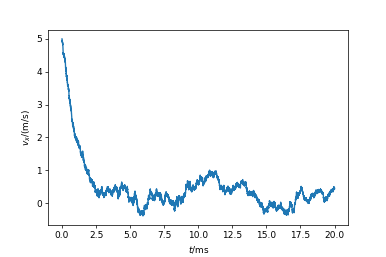

Final velcoity in x-direction: 0.4584703


In [59]:
times = []
for i in range(len(data)):
    times.append(i*dt)
plt.figure()
plt.plot(1.0e3 * np.array(times), data[:,3,0])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$v_x/(\rm{m}/\rm{s})$')
print("Final velcoity in x-direction: " + str(data[-1,3,0]))

/tmp/ipykernel_7411/4218053474.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ma_pos = np.array([ma_posx, ma_posy, [0] * num_particles])


<IPython.core.display.Javascript object>


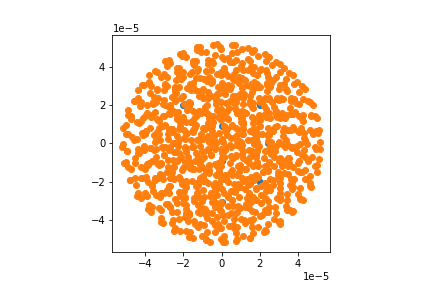

In [37]:
from scipy.optimize import minimize

ma_posx = [-8.80378877e-14, -2.00400157e-05,  2.00400157e-05,  2.45180411e-05,
  2.00400157e-05, -9.47046622e-14, -2.45180410e-05, -5.06892235e-14,
 -7.51007479e-16, -2.00400156e-05]
ma_posy = [9.16801357e-06,  2.01849643e-05,
  2.01849644e-05, -3.33118772e-14, -2.01849643e-05, -9.16801358e-06,
 -6.91825536e-14,  3.07232821e-05, -3.07232821e-05, -2.01849643e-05]

ma_pos = np.array([ma_posx, ma_posy, [0] * num_particles])

damping_posx = load_pos_rot3D[-1,0]
damping_posy = load_pos_rot3D[-1,1]
damping_posz = load_pos_rot3D[-1,2]
damping_velx = load_vel_rot3D[-1,0]
damping_vely = load_vel_rot3D[-1,1]
damping_velz = load_vel_rot3D[-1,2]
damping_pos = np.array([damping_posx, damping_posy, damping_posz])
damping_vel = np.array([damping_velx, damping_vely, damping_velz])

'''
def err2(theta, damping_posx,damping_posy,ma_posx,ma_posy):
    rot_x = damping_posx*np.cos(theta)-damping_posy*np.sin(theta)
    rot_y = damping_posx*np.sin(theta)+damping_posy*np.cos(theta)
    error = np.sum(np.sqrt((ma_posx-rot_x)**2+(ma_posy-rot_y)**2))
    return error

err = minimize(err2, -2.12506464, args = (damping_posx,damping_posy,ma_posx,ma_posy), method='CG')
print(err)
print(err2(-2.12506464,damping_posx,damping_posy,ma_posx,ma_posy)) 

theta = 0
rot_x = damping_posx*np.cos(theta)-damping_posy*np.sin(theta)
rot_y = damping_posx*np.sin(theta)+damping_posy*np.cos(theta)
'''

'''
rot_x = np.empty(len(ma_posx))
rot_y = np.empty(len(ma_posx))
for i in range(len(ma_posx)):
    rot_x[i] = damping_posx[i]*np.cos(theta)-damping_posy[i]*np.sin(theta)
    rot_y[i] = damping_posx[i]*np.sin(theta)+damping_posy[i]*np.cos(theta)
'''
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect("equal")
ax.plot(ma_posx,ma_posy, linestyle = " ", marker = 'o')
ax.plot(damping_posx,damping_posy, linestyle=" ", marker = 'o')

In [11]:
m = 9.012182*1.66057e-27
q = 1.602176597458587e-19
wz = 2*np.pi*1.58e6
wc = 4.4588*q/m
wr = 180000*2*np.pi
V0=(0.5 * m * wz**2) / q
Volt_w = 5
Volt_0 = V0 
delta = 1612.*Volt_w / Volt_0
Vw = 0.5*(m*wz**2/q)*delta
eps0 = 8.85418782*10**-12

def pot_eng_ax_pl_trap(position):
    shape   = np.shape(position)
    dims,ions=shape
    x = position[0,:]
    y = position[1,:]
    z = position[2,:]
    pot_eng_ion = np.zeros((ions,2))
    pot_eng_ion[:,0] = 0.5*m*wz**2*np.square(z)
    pot_eng_ion[:,1] += -0.5*m*(wr**2 - wr*wc + 0.5*wz**2) *(np.square(x)+np.square(y))
    pot_eng_ion[:,1] += q*Vw*(np.square(x)-np.square(y))
    return pot_eng_ion

def pot_eng_coul(position):
    shape   = np.shape(position)
    dims,ions=shape
    x = position[0,:]
    y = position[1,:]
    z = position[2,:]
    pot_eng_ion = np.zeros(ions)
    for ion1 in range(ions):
        for ion2 in range(ions):
            if ion1!=ion2:
                dx = x[ion1] - x[ion2]
                dy = y[ion1] - y[ion2]
                dz = z[ion1] - z[ion2]
                r = np.sqrt(dx**2 + dy**2 + dz**2)
                pot_eng_ion[ion1] += q**2/(4*np.pi*eps0*r)
    return pot_eng_ion/2

    
    


In [12]:
pot_en_rot =0
pot_en_ma = 0
ke = 0

for i in range(len(ma_posx)):
    #this_vel= np.sqrt((pos_rot3D[-2,0,i]-pos_rot3D[-1,0,i])**2+(pos_rot3D[-2,1,i]-pos_rot3D[-1,1,i])**2+(pos_rot3D[-2,2,i]-pos_rot3D[-1,2,i])**2)/(write_per*dt)
    #print(this_vel)
    for j in range(len(ma_posx)):
        if i != j:
            pot_en_ma += 1/np.sqrt((ma_posx[i]- ma_posx[j])**2+(ma_posy[i]- ma_posy[j])**2)
            pot_en_rot += 1/np.sqrt((damping_posx[i]- damping_posx[j])**2+(damping_posy[i]- damping_posy[j])**2)
            
#print(pot_en_ma/2)
#print(pot_en_rot/2)
sim_en_coul = np.sum(pot_eng_coul(damping_pos))
print(sim_en_coul)
sim_en_trp = np.sum(pot_eng_ax_pl_trap(damping_pos))
print(sim_en_trp)
sim_en = sim_en_coul+sim_en_trp
print(sim_en)

ma_en_coul = np.sum(pot_eng_coul(ma_pos))
ma_en_trp = np.sum(pot_eng_ax_pl_trap(ma_pos))
print(ma_en_coul)
print(ma_en_trp)
ma_en = ma_en_coul+ma_en_trp
print(ma_en)


KeyboardInterrupt: 

In [13]:
def pot_eng_ax_pl_trap(position,beta,delta):
    """positions must be normalized by ma.l0 from
        mode analysis code"""
    shape   = np.shape(position)
    dims,ions=shape
    x = position[0,:]
    y = position[1,:]
    z = position[2,:]
    pot_eng_ion = np.zeros((ions,2))
    pot_eng_ion[:,0] = np.square(z)
    pot_eng_ion[:,1] += beta *(np.square(x)+np.square(y))
    pot_eng_ion[:,1] += delta*(np.square(x)-np.square(y))
    return pot_eng_ion

def pot_eng_coul(position):
    """positions must be normalized by ma.l0 from
        mode analysis code"""
    shape   = np.shape(position)
    dims,ions=shape
    x = position[0,:]
    y = position[1,:]
    z = position[2,:]
    pot_eng_ion = np.zeros(ions)
    for ion1 in range(ions):
        for ion2 in range(ions):
            if ion1!=ion2:
                dx = x[ion1] - x[ion2]
                dy = y[ion1] - y[ion2]
                dz = z[ion1] - z[ion2]
                r = np.sqrt(dx**2 + dy**2 + dz**2)
                pot_eng_ion[ion1] += 1/r
    return pot_eng_ion/2

In [100]:
num_ions=10
mass_amu=9.012182
vtrap=(0.0, -1750.0, -1970.0)
v_wall=5.
frot=180000
method='bfgs'
frot_kHz = 1e-3*frot 
ma_instance=ma.ModeAnalysis(
            N      = num_ions,
            ionmass= mass_amu,
            Vtrap  = vtrap,
            omega_z = 2*np.pi*1.58e6,
            Vwall  = v_wall,
            frot   = frot_kHz,
            method = method)
ma_instance.run()

sim_en_coul = np.sum(pot_eng_coul(damping_pos/ma_instance.l0))
print(sim_en_coul)
sim_en_trp = np.sum(pot_eng_ax_pl_trap(damping_pos/ma_instance.l0, ma_instance.beta, ma_instance.delta))
print(sim_en_trp)
sim_en = sim_en_coul+sim_en_trp
print(sim_en)

ma_en_coul = np.sum(pot_eng_coul(ma_pos/ma_instance.l0))
ma_en_trp = np.sum(pot_eng_ax_pl_trap(ma_pos/ma_instance.l0, ma_instance.beta, ma_instance.delta))
print(ma_en_coul)
print(ma_en_trp)
ma_en = ma_en_coul+ma_en_trp
print(ma_en)


(20,)
9.496680230818123
5.133512990146636
14.63019322096476
9.746767266631743
4.873383631810359
14.620150898442102


In [101]:
(14.63019322096476-14.620150898442102)/14.620150898442102

0.0006868822758681575

In [39]:
%matplotlib inline
write_per = 1000
kb = 1.380649*10**-23
times_rec = 101

def KE_arr(vels): # returns 2d array: index 1 is timestep and index 2 is mean particle KE
    ret_arr = np.zeros((times_rec, 2))
    for i in range(vels.shape[0]): #i indexes timestep
        this_energy = 0
        for j in range(num_particles):
            this_energy += 0.5*masses[0]*(vels[i,0,j]**2 +vels[i,1,j]**2 +vels[i,2,j]**2)
            #this_energy += 0.5*masses[0]*(vel_rot3D[i,1,j]**2)
        ret_arr[i, 0] = i*write_per*dt
        ret_arr[i, 1] = this_energy/num_particles
    return ret_arr

def Vel_arr_old(vels): # returns 2d array: index 1 is timestep and index 2 is mean particle KE
    ret_arr = np.zeros((times_rec, 1+num_particles))
    for i in range(vels.shape[0]): #i indexes timestep
        this_vel = 0
        for j in range(num_particles):
            #this_energy += 0.5*masses[0]*(vel_rot3D[i,0,j]**2 +vel_rot3D[i,1,j]**2 +vel_rot3D[i,2,j]**2)
            this_vel= np.sqrt(vels[i,0,j]**2+vels[i,1,j]**2+vels[i,2,j]**2)
            #this_vel= vel_rot3D[i,1,j]
            ret_arr[i, 1+j] = this_vel
        ret_arr[i, 0] = i*write_per*dt
    return ret_arr

def Vel_arr(vels): # returns 2d array: index 1 is timestep and index 2 is mean particle KE
    ret_arr = np.zeros((times_rec, 2))
    for i in range(vels.shape[0]): #i indexes timestep
        this_vel = 0
        for j in range(num_particles):
            #this_energy += 0.5*masses[0]*(vel_rot3D[i,0,j]**2 +vel_rot3D[i,1,j]**2 +vel_rot3D[i,2,j]**2)
            this_vel+= np.sqrt(vels[i,0,j]**2+vels[i,1,j]**2+vels[i,2,j]**2)
            #this_vel= vel_rot3D[i,1,j]
        ret_arr[i, 1] = this_vel/num_particles
        ret_arr[i, 0] = i*write_per*dt
    return ret_arr

def temp_arr(vels): # returns 2d array: index 1 is timestep and index 2 is mean particle KE
    ret_arr = np.zeros((times_rec, 2))
    for i in range(vels.shape[0]): #i indexes timestep
        this_vel = 0
        for j in range(num_particles):
            #this_energy += 0.5*masses[0]*(vel_rot3D[i,0,j]**2 +vel_rot3D[i,1,j]**2 +vel_rot3D[i,2,j]**2)
            this_vel+= np.sqrt(vels[i,0,j]**2+vels[i,1,j]**2+vels[i,2,j]**2)
            #this_vel= vel_rot3D[i,1,j]
        ret_arr[i, 1] = (this_vel/num_particles)**2*masses[0]*np.pi/(8*kb)
        ret_arr[i, 0] = i*write_per*dt
    return ret_arr

(array([0.e+00, 1.e-07, 2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

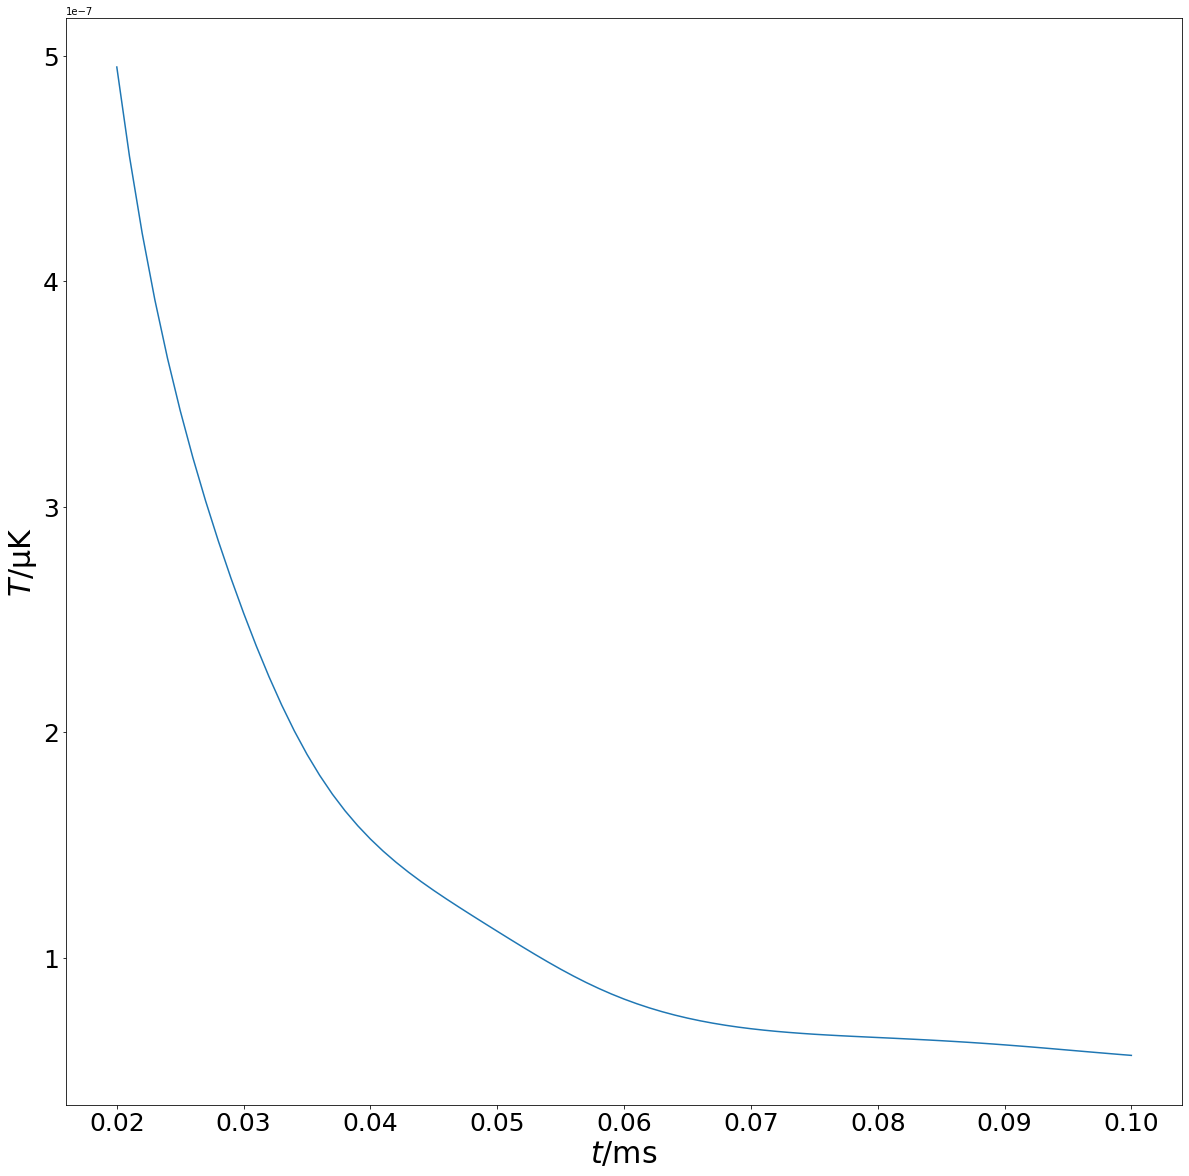

In [47]:
ke_arr = KE_arr(load_vel_rot3D)
#temp_arr1 = temp_arr(load_vel_rot3D)
plt.figure(figsize=(20, 20))
#plt.figure()
plt.plot(1.0e3 * ke_arr[20:,0], 6.6415*10**21*ke_arr[20:,1])
plt.xlabel(r'$t/\rm{ms}$',fontsize = 30)
plt.ylabel(r'$T/\rm{\mu K}$',fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

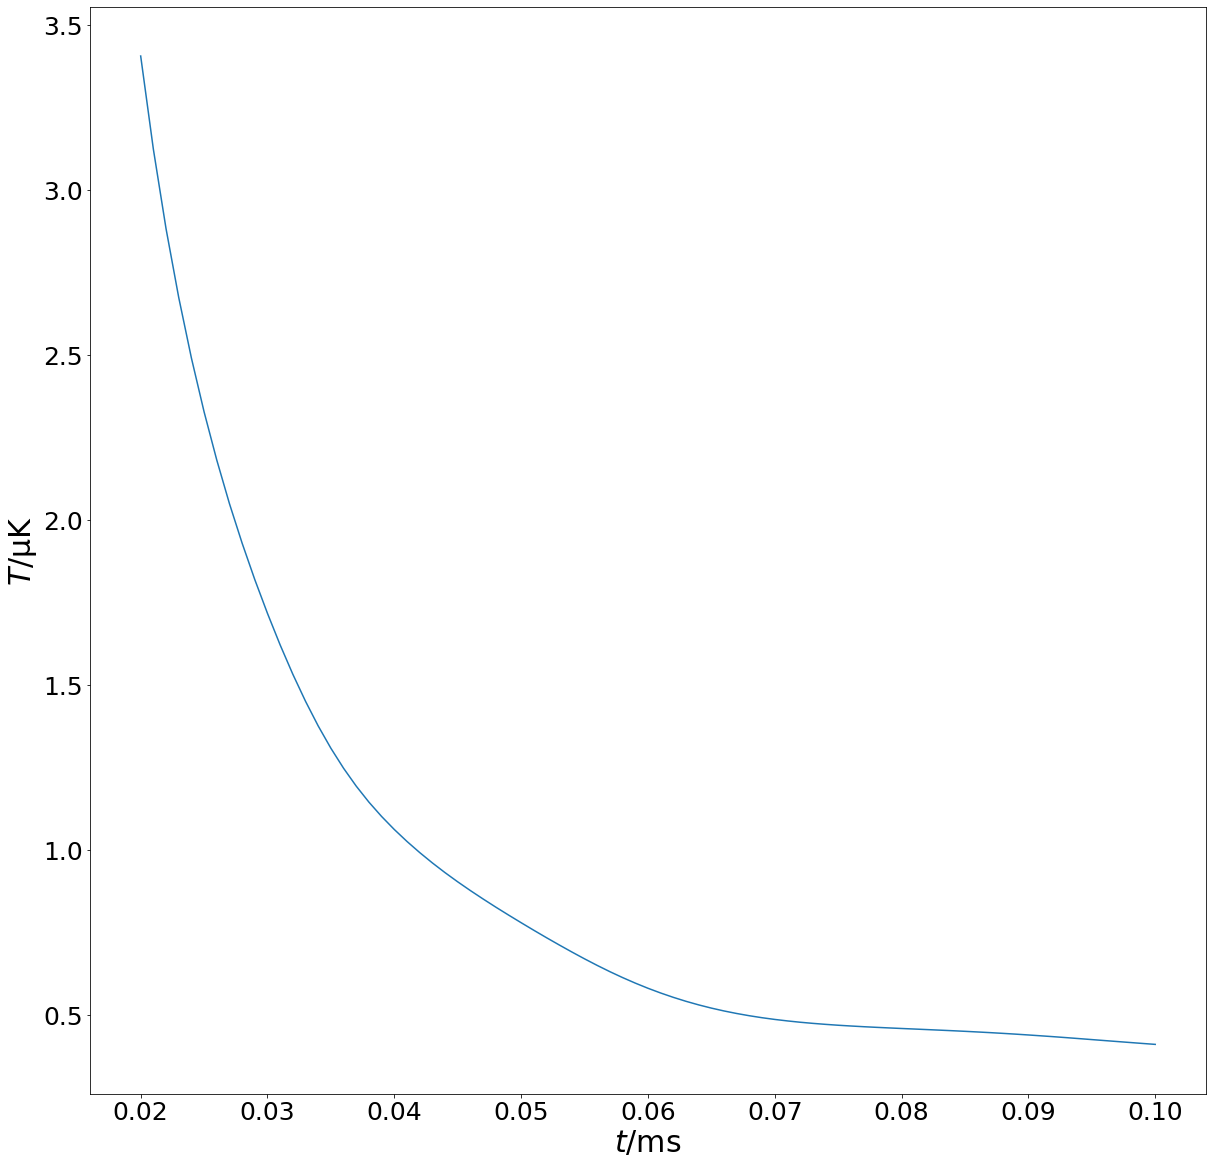

In [45]:
#ke_arr = KE_arr(load_vel_rot3D)
temp_arr1 = temp_arr(load_vel_rot3D)
plt.figure(figsize=(20, 20))
plt.plot(1.0e3 * temp_arr1[20:,0], 10**6*temp_arr1[20:,1])
plt.xlabel(r'$t/\rm{ms}$',fontsize = 30)
plt.ylabel(r'$T/\rm{\mu K}$',fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

(array([0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 , 0.0045, 0.005 ,
        0.0055, 0.006 , 0.0065]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

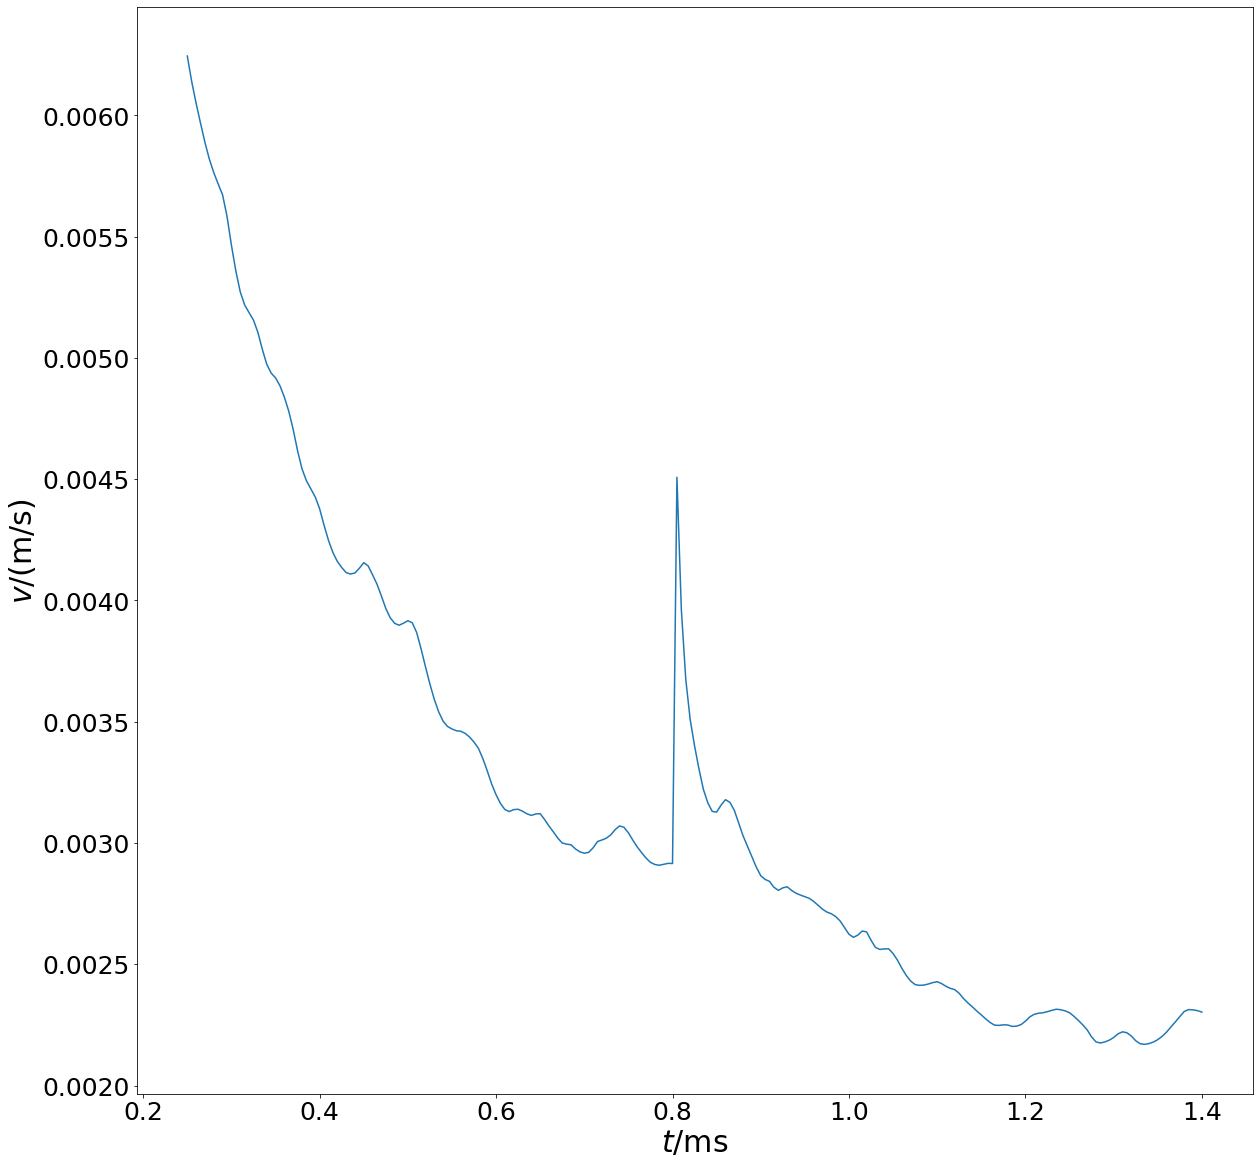

In [25]:
Vel_arr1 = Vel_arr(load_vel_rot3D)
#temp_arr1 = temp_arr(load_vel_rot3D)
plt.figure(figsize=(20, 20))
plt.plot(1.0e3 * Vel_arr1[50:,0], Vel_arr1[50:,1])
plt.xlabel(r'$t/\rm{ms}$',fontsize = 30)
plt.ylabel(r'$v/(\rm{m/s})$',fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

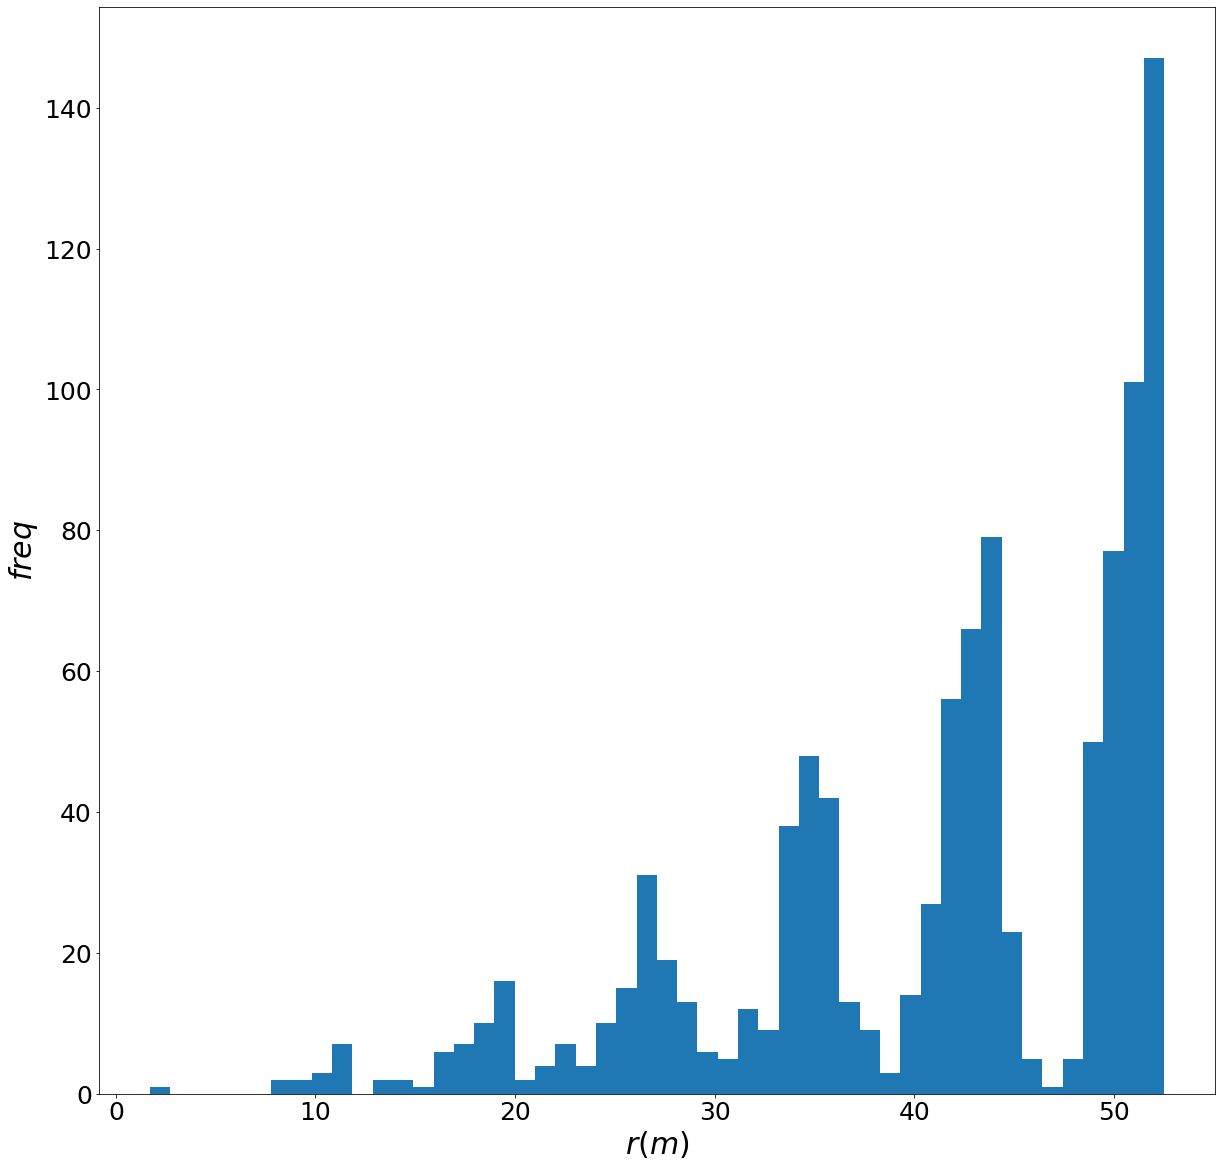

In [43]:
%matplotlib inline
plt.figure(figsize=(20, 20))
rad_list = np.sqrt(load_pos_rot3D[-1,0,:]**2+load_pos_rot3D[-1,1,:]**2+load_pos_rot3D[-1,2,:]**2)
plt.hist(10**6*rad_list,50)
plt.xlabel(r'$r(m)$', fontsize = 30)
plt.ylabel(r'$freq$', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


'\nz_list = np.linspace(-110,110,1000)\nplt.plot(np.sqrt(116.8**2-z_list**2),z_list)\nplt.plot(np.sqrt(109**2-z_list**2),z_list)\nplt.plot(np.sqrt(101**2-z_list**2),z_list)\nplt.plot(np.sqrt(93**2-z_list**2),z_list)\n'

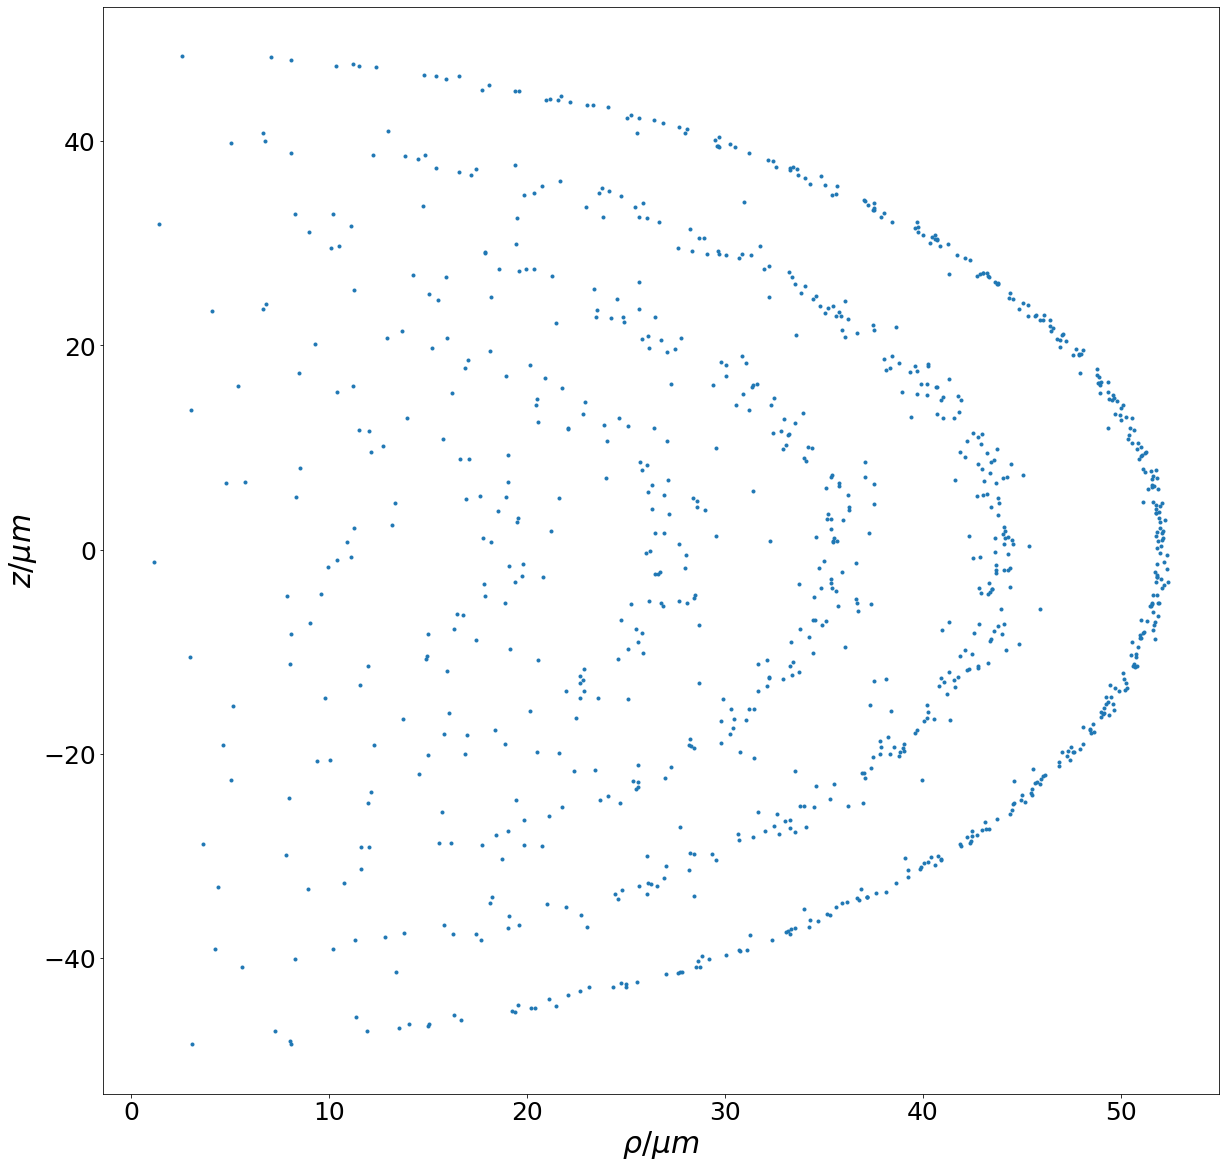

In [44]:
rho_list = np.sqrt(load_pos_rot3D[-1,0,:]**2+load_pos_rot3D[-1,1,:]**2)
plt.figure(figsize=(20, 20))
#plt.figure()
plt.plot(10**6*rho_list, 10**6*load_pos_rot3D[-1,2,:], linestyle = " ", marker = ".")
plt.xlabel(r'$\rho/\mu m$', fontsize = 30)
plt.ylabel(r'$z/\mu m$', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
'''
z_list = np.linspace(-110,110,1000)
plt.plot(np.sqrt(116.8**2-z_list**2),z_list)
plt.plot(np.sqrt(109**2-z_list**2),z_list)
plt.plot(np.sqrt(101**2-z_list**2),z_list)
plt.plot(np.sqrt(93**2-z_list**2),z_list)
'''

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([2.52022275e-07, 3.56740073e-07, 4.61457871e-07, ...,
        1.04760385e-04, 1.04865102e-04, 1.04969820e-04]),
 array([-0.00036852, -0.00036779, -0.00036705, ...,  0.000367  ,
         0.00036774,  0.00036848]),
 <matplotlib.collections.QuadMesh at 0x7fdc302416d0>)

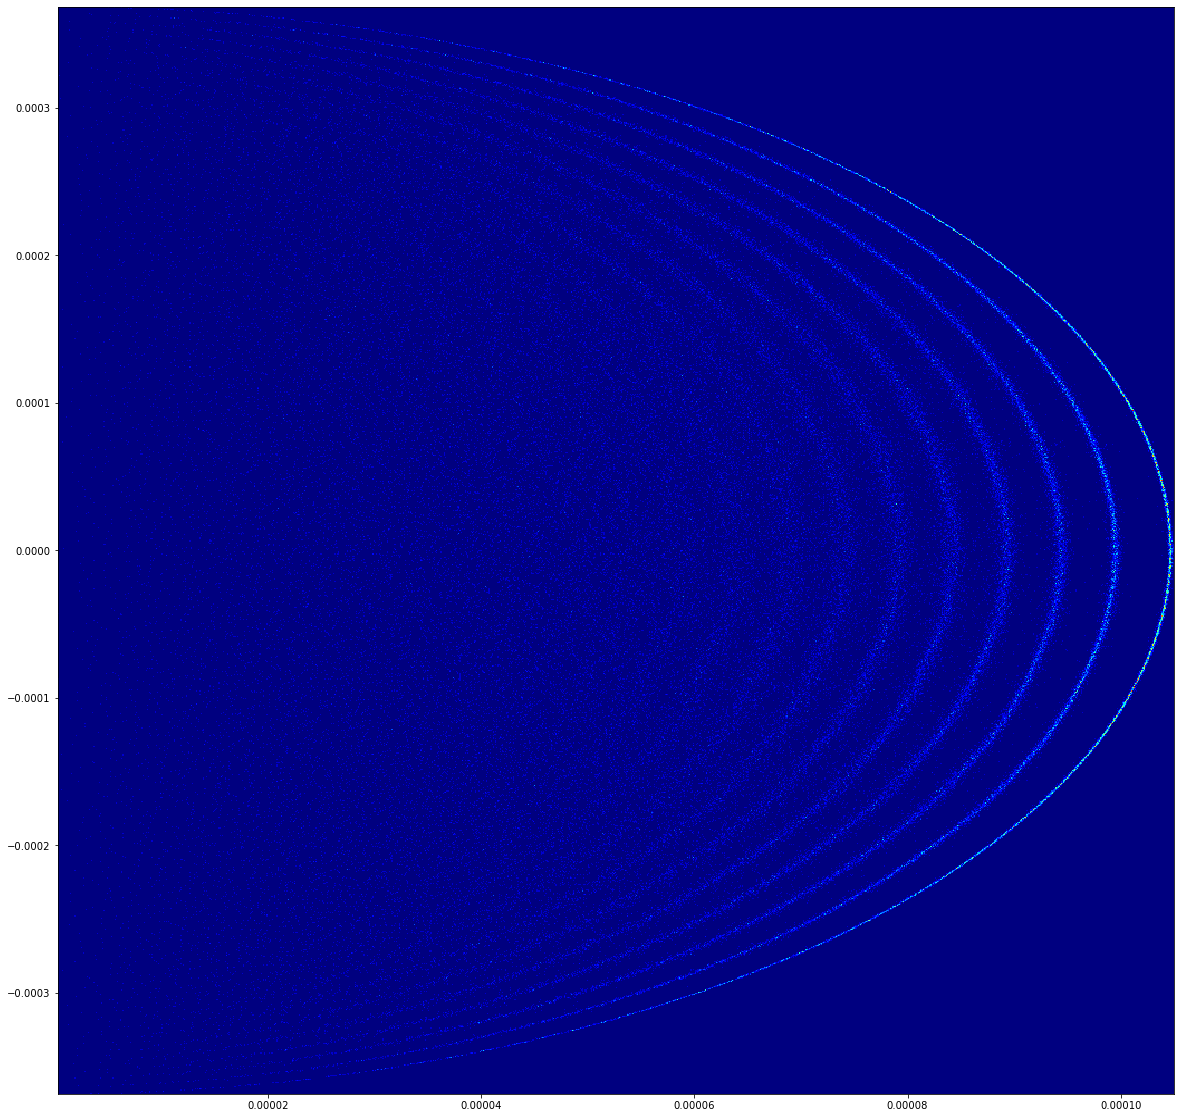

In [20]:
plt.figure(figsize=(20, 20))
plt.hist2d(rho_list, load_pos_rot3D[-1,2,:], 1000, cmap=plt.cm.jet)

<IPython.core.display.Javascript object>


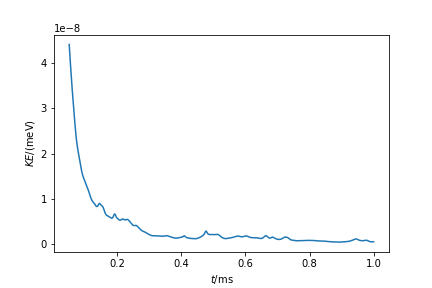

Text(0, 0.5, '$KE/(\\rm{meV})$')

In [45]:
ke_arr = KE_arr(vel_rot3D)
plt.figure()
plt.plot(1.0e3 * ke_arr[100:,0], 6.2415093433e21*ke_arr[100:,1])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$KE/(\rm{meV})$')

<IPython.core.display.Javascript object>


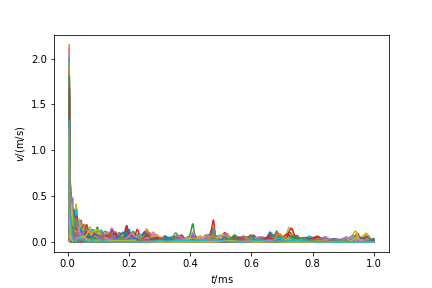

Text(0, 0.5, '$v/(\\rm{m}/\\rm{s})$')

In [43]:
#vel_arr = Vel_arr(vel_rot3D)
start = 10
stop = -1
plt.figure()
for i in range(num_particles):
    plt.plot(1.0e3 * vel_arr[start:stop,0], vel_arr[start:stop,i+1])
plt.xlabel(r'$t/\rm{ms}$')
plt.ylabel(r'$v/(\rm{m}/\rm{s})$')

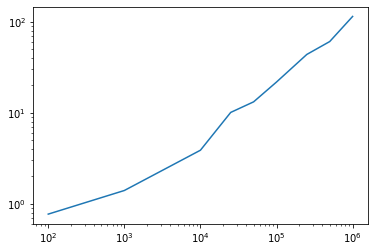

In [26]:
ions = [100,1000,10000,25000,50000,100000,250000,500000,1000000]
times = [0.77,1.4,3.88,10.1,13.2,21.8,43.8,60.7,114.6]

plt.loglog(ions,times)